## SAC: discrete action, simplified

soft actor-critic

最大化动作的熵,增强模型的稳定性

$$
Q(s, a) + α \text{Entropy}[Q(s, *)]
$$

训练时$α$固定，并且只用一个Value模型评估Q函数

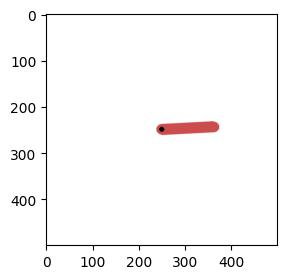

In [2]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('Pendulum-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step([action * 2])
    over = terminated or truncated

    # 偏移reward便于训练
    reward = (reward + 8) / 8
    
    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
      over = True

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [3]:
import torch
	
# 演员模型：计算动作概率
class ModelAction(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.s = torch.nn.Sequential(
      torch.nn.Linear(3, 64),
      torch.nn.ReLU(),
      torch.nn.Linear(64, 64),
      torch.nn.ReLU(),
    )
    
    self.mu = torch.nn.Sequential(
      torch.nn.Linear(64, 1),
      torch.nn.Tanh(),
    )
    self.sigma = torch.nn.Sequential(
      torch.nn.Linear(64, 1),
      torch.nn.Tanh(),
    )
  def forward(self, state):
    state = self.s(state)
    return self.mu(state), self.sigma(state).exp()
 
model_action = ModelAction()
model_action(torch.randn(2, 3))

(tensor([[0.1118],
         [0.1651]], grad_fn=<TanhBackward0>),
 tensor([[1.0494],
         [1.1032]], grad_fn=<ExpBackward0>))

In [4]:
model_value = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 1),
)

model_value_next = torch.nn.Sequential(
	torch.nn.Linear(4, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 64),
	torch.nn.ReLU(),
	torch.nn.Linear(64, 1),
)


model_value_next.load_state_dict(model_value.state_dict())
model_value(torch.randn(2, 4))

tensor([[-0.0693],
        [-0.1362]], grad_fn=<AddmmBackward0>)

In [6]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    # 根据环境采样
    mu, sigma = model_action(torch.FloatTensor(state).reshape(1, 3))
    action = random.normalvariate(mu=mu.item(), sigma=sigma.item())

    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))
    reward_sum += reward
    
    state = next_state

    if show:
      display.clear_output(wait=True)
      env.show()

  return data, reward_sum

play()[-1]

71.65135911632228

In [7]:
class Pool:
  
  def __init__(self):
    self.pool = []
    
  def __len__(self):
    return len(self.pool)
  
  def __getitem__(self, i):
    return self.pool[i]
  
  # 更新动作
  def update(self):
    # 每次更新至少N条数据
    old_len = len(self.pool)
    while len(pool) - old_len < 200:
      self.pool.extend(play()[0])
      
    # 保留最新N条数据
    self.pool = self.pool[-2_0000:]
    
  def sample(self):
    data = random.sample(self.pool, 64)
    
    state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)
    action = torch.FloatTensor([i[1] for i in data]).reshape(-1, 1)
    reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
    next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 3)
    over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)
    
    return state, action, reward, next_state, over
  
pool = Pool()
pool.update()
state, action, reward, next_state, over = pool.sample()
len(pool), pool[0]

C:\Users\fanyu\AppData\Local\Temp\ipykernel_14600\1686063259.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 3)


(200,
 (array([ 0.48410323,  0.8750109 , -0.10222378], dtype=float32),
  -0.06000919539654043,
  0.8579674028090643,
  array([0.4604805, 0.8876698, 0.5360316], dtype=float32),
  False))

In [9]:
optimizer_action = torch.optim.Adam(model_action.parameters(), lr=5e-4)
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=5e-3)


def soft_update(_from, _to):
  for _from, _to in zip(_from.parameters(), _to.parameters()):
    value = _to.data * 0.995 + _from.data * 0.005
    _to.data.copy_(value)
    
def get_action_entroy(state):
  mu, sigma = model_action(torch.FloatTensor(state).reshape(-1, 3))
  dist = torch.distributions.Normal(mu, sigma)
  
  action = dist.rsample()
  
  return action, sigma
    
def requires_grad(model, value):
  for param in model.parameters():
    param.requires_grad_(value)

In [10]:
# critic 模型训练
def train_value(state, action, reward, next_state, over):
  requires_grad(model_value, True)
  requires_grad(model_action, False)
  
  # 计算targets
  with torch.no_grad():
    # 计算动作熵
    next_action, entropy = get_action_entroy(next_state)
    
    # 评估next_state价值
    input = torch.cat([next_state, next_action], dim=1)
    target = model_value_next(input)
    
  # 加权熵，越大越好
  target = target + 5e-3 * entropy
  target = target * 0.99 * (1 - over) + reward
  
  # 计算value
  value = model_value(torch.cat([state, action], dim=1))
  
  loss = torch.nn.functional.mse_loss(value, target)
  
  loss.backward()
  optimizer_value.step()
  optimizer_value.zero_grad()
  
  return loss.item()

train_value(state, action, reward, next_state, over)

0.3770737051963806

In [11]:
# 训练actor
def train_action(state):
  requires_grad(model_action, True)
  requires_grad(model_value, False)
  
  # 计算熵
  action, entropy = get_action_entroy(state)
  
  # 计算value
  value = model_value(torch.cat([state, action], dim=1))
  
  # 加权熵
  loss = -(value + 5e-3 * entropy).mean()
  
  # 使用model_value计算model_action的loss
  loss.backward()
  optimizer_action.step()
  optimizer_action.zero_grad()
  
  return loss.item()

train_action(state)

-0.11048859357833862

In [12]:
#训练
def train():
  model_action.train()
  model_value.train()

	# 共更新N轮数据
  for epoch in range(200):
    # 更新N条数据
    pool.update()
    
    # 每次更新过数据后,学习N次
    for i in range(200):
      # 采样一批
      state, action, reward, next_state, over = pool.sample()

      # 训练
      train_value(state, action, reward, next_state, over)
      train_action(state)
      soft_update(model_value, model_value_next)

    if epoch % 10 == 0:
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      print(epoch, len(pool), test_result)

train()

0 400 -7.514155944258805
10 2400 25.754206168141117
20 4400 170.5237385643297
30 6400 173.52128826888588
40 8400 181.0996780462193
50 10400 176.22230261133765
60 12400 169.07225215488756
70 14400 172.0458041352938
80 16400 164.51358475688093
90 18400 174.91340305582602
100 20000 177.36928121805195
110 20000 180.32899372617146
120 20000 93.61343487315551
130 20000 181.7154805319696
140 20000 175.80455643845514
150 20000 166.53411429963836
160 20000 180.20399339066523
170 20000 180.77739054622208
180 20000 173.80450234376138
190 20000 177.50072569777726


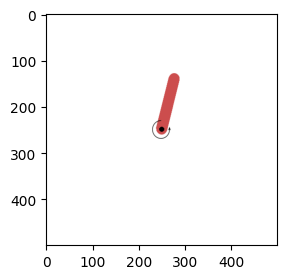

183.2736874696301

In [13]:
play(True)[-1]